In [63]:
import numpy as np
from pynbody import array, new, snapshot, units
from pynbody import gadget, grafic, nchilada, ramses, tipsy
import pynbody as pyn
import math
import pynbody.plot.sph as sph
import matplotlib.pylab as plt
import scipy

In [47]:
#First attempt at initialization
sim = pyn.new(1000)
sim['pos'] = np.random.normal(scale=1.0,size=sim['pos'].shape)
sim['vel'] = np.random.normal(scale=1.0,size=sim['vel'].shape)
sim['mass'] = np.random.normal(1.0, 2.0,size=sim['mass'].shape)
sim['eps'] = .1
sim['pos'].units= 'kpc'
sim['vel'].units= 'km s^-1'
sim['mass'].units= 'Msol'

In [96]:
#writing out: first argument determines what kind of file it outputs as. not sure what default is, or if there is one.
sim.write(tipsy.TipsySnap,'writeTest.out')

/home/willlum/.local/lib/python3.6/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'a'=1.00e+00
  name, value), RuntimeWarning)


In [79]:
#seeing if different kinds of particles can be initialized.
sim3 = pyn.new(gas=1000,star=1000,dm=1000)

In [81]:
sim3.dm['pos'] = np.random.normal(scale=1.0,size=sim3.dm['pos'].shape)

In [48]:
#early attempt at initializi
def velX(x,y):
    r= np.sqrt(x**2+y**2)
    thet= np.arctan2(y,x)
    vr= r*(1+2*r)**(-7/8)*(1+r/5)**(-5/8)  #rotation curve from Sellwood et. al.
    vx= vr*np.cos(thet)*vr
    return vx
def velY(x,y):
    r= np.sqrt(x**2+y**2)
    thet= np.arctan2(y,x)
    vr= r*(1+2*r)**(-7/8)*(1+r/5)**(-5/8) #rotation curve from Sellwood et. al.
    vx= vr*np.sin(thet)*vr
    return vx
sim3 = pyn.new(star=1000,dm=9000)
sim3.star['x'] = np.random.normal(-10.5,10.5)
sim3.star['vz'] = np.random.normal(-.1,.1)
sim3.star['vx'] = velX(sim3.star['x'],sim3.star['y'])
sim3.star['vy'] = velY(sim3.star['x'],sim3.star['y'])
sim3.star['mass'] = np.random.normal(1.0, 2.0,size=sim3.star['mass'].shape)
sim3.star['eps'] = .01
sim3.dm['pos'] = np.random.normal(scale=1.0,size=sim3.dm['pos'].shape)
sim3.dm['mass'] = np.random.normal(-1.5, 1.5)
sim3.dm['vx'] = velX(sim3.dm['x'],sim3.dm['y'])
sim3.dm['vy'] = velY(sim3.dm['x'],sim3.dm['y'])
sim3.dm['eps'] = .075
sim3['pos'].units= 'kpc'
sim3['vel'].units= 'km s^-1'
sim3['mass'].units= 'Msol'

In [206]:
#
# Some "helper" functions to feed into genPartList
#
def noahDenFunc(r):
    return ((1+20*r*1/1.5)**(-.75)*(1+r*1/7.5)**(-2.5)/3.96716)
def dmHaloFunc(r):
    return ((1/((1+r/10.0)**3))/250.87)
def vt(r,disp):#ripped out of sellwood paper, implementation of velocity dispersion. Lets see how this works out.
    return np.random.normal(r/1.5*(1+2*r/1.5)**(-.875)*(1+r/7.5)**(-.625),disp) 
def vr(r,disp):
    return np.random.normal(0,disp)
def veltX(r,theta, rotafunc,disp):
    return math.sin(theta)*rotafunc(r,disp)
def veltY(r,theta, rotafunc,disp):
    return -math.cos(theta)*rotafunc(r,disp)# I think the - sign might fix things, we'll see.
def velrX(r,theta, rotafunc,disp):
    return math.cos(theta)*rotafunc(r,disp)
def velrY(r,theta, rotafunc,disp):
    return math.sin(theta)*rotafunc(r,disp)
#
# Generates a list of three different lists, in order: [x,y,z] position, [x,y,z] velocity, and radius.
# Overall goal is to generate particles that roughly correspond to a specific density distribution.
#
def genPartList(rmax,ntot,nbins,denFunc,rotafunc): #assumes radial symmetry on function. Produces list of particles locations.
    n=0.0 
    starList=[]
    velList=[]
    rList=[]
    dr = rmax/nbins #nbins is the "specificity" of the distribution, ntot is the average number of particles, rmax is the cutoff radius of the disk.
    while n < ntot:
        r=0.0
        while r < rmax: #important to note that rmax is a hard cutoff.
            if(np.random.random() < denFunc(r+dr/2)*r*dr*2*math.pi):
                rt=r+np.random.random()*dr
                vdisp=vDisp(rt)
                thetem=np.random.random()*2*math.pi
                x=rt*math.cos(thetem)
                vx=veltX(rt,thetem,vt,vdisp)+velrX(rt,thetem,vr,vdisp)
                y=rt*math.sin(thetem)
                vy=veltY(rt,thetem,vt,vdisp)+velrY(rt,thetem,vr,vdisp)
                z=np.random.normal(0,.105) #sort of a placeholder: will add distribution option eventually.
                vz=0
                starList.append([x,y,z])
                velList.append([vx,vy,vz])
                rList.append(rt)
            r+=dr
        n+=1
    return [starList,velList,rList]

In [207]:
#
# Standard simpson integral
#
def simpson(f, xn,x0,n):
    x=f(x0)+f(xn)
    dx=(xn-x0)/n
    k=1
    while k <= n-1:
        x+=4*f(x0+k*dx)
        k+=2
    k=2
    while k <= n-2:
        x+=2*f(x0+k*dx)
        k+=2
    return x*dx/3
#
# Calculator for initial potential. uses simpson integral.
#
G= 6.67e-11
#
m=50000000
#
def calcPhi(f, r, nbin): #figure out how to calculate gravitational potential of the simulation
    return simpson(f,r,0,nbin)*G*m/r

In [208]:
#
# Some specific potential functions. collapses into single function for sake of simpson integration.
#
def starpot(r):
    return noahDenFunc(r)*2*math.pi*r*np.heaviside(10.5-r,1)
def dmpot(r):
    return dmHaloFunc(r)*2*math.pi*r
#
# Defining velocity dispersion as function of radius.
# Within scope of noah's thesis, radial and azimuthal velocity dispersions are the same. 
# See page 46 of Noah's Thesis for more details.
#
Q=1.2 #Empirical detail ripped out of Noah's thesis.
def vDisp(r):
    sigmar = noahDenFunc(r)
    k=np.sqrt(r*dOmSqdr(r)+4*OmSq(r))
    return 3.36*sigmar*Q/k
#
# helper functions for vDisp
# These are the frequencies at which particles at perfectly circular orbits would rotate. Not sure if I have to incorporate dm distribution also.
#
def OmSq(r):
    return r**3/(G*simpson(starpot,r,0,100))#simpson calculation here represents value of mass
def dOmSqdr(r):
    m= simpson(starpot,r,0,100) #derivative of omega squared I think? thesis is not entirely clear about this
    return (3*r**2/m-starpot(r)*r**3/m**2)/G

In [215]:
starList = genPartList(10.5,2000,1000,noahDenFunc,vr)
dmList = genPartList(84.0,18000,1000,dmHaloFunc,vr)
#
#
len(dmList[0]) #just there to see if particle counts were correct

1778

In [217]:
noahSim = pyn.new(gas=len(starList[0]),star=len(starList[0]),dm=len(dmList[0]))
#
noahSim['pos'].units= 'kpc'
noahSim['vel'].units= 'km s^-1'
noahSim['mass'].units= 'Msol'
#
sl2=np.asarray(starList[2])#translating from one file format to another: functions will take np arrays, but not lists
dl2=np.asarray(dmList[2])# 
#
# Setting position, velocity, softening length, mass, and potential for stars
#
noahSim.star['pos']=starList[0]
noahSim.star['vel']=starList[1]
noahSim.star['eps']=.075
noahSim.star['mass']=50000000
noahSim.star['phi']=(calcPhi(starpot,sl2,1000)*len(sl2)+calcPhi(dmpot,sl2,84)*len(dl2))
#
# Same as above, but for dark matter
#
noahSim.dm['pos']=dmList[0]
noahSim.dm['vel']=dmList[1]
noahSim.dm['eps']=.075
noahSim.dm['mass']=50000000
noahSim.dm['phi']=(calcPhi(starpot,dl2,1000)*len(sl2)+calcPhi(dmpot,dl2,84)*len(dl2))
#
# Lazy shortcut way of doing gas. More sophisticated method in the future, probably..
#
noahSim.gas['x']=noahSim.star['y']
noahSim.gas['vx']=noahSim.star['vy']
noahSim.gas['y']=-noahSim.star['x']
noahSim.gas['vy']=-noahSim.star['vx']
noahSim.gas['eps']=.075
noahSim.gas['mass']=5000000
noahSim.gas['phi']=(calcPhi(starpot,sl2,1000)*len(sl2)+calcPhi(dmpot,sl2,84)*len(dl2))/10
#
#
noahSim['a']=1.5 #not wure what this is for
#
# Setting units and outputting .out into curent folder.
#
noahSim.write(tipsy.TipsySnap,'protenCor.out')

/home/willlum/.local/lib/python3.6/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'a'=1.00e+00
  name, value), RuntimeWarning)


SimArray([[37855.152, 38332.277, 38809.406, ..., 31263.812, 31077.04 ,
           30890.264],
          [38075.18 , 38554.883, 39034.586, ..., 31161.227, 30982.566,
           30803.904],
          [38295.207, 38777.49 , 39259.766, ..., 31058.645, 30888.094,
           30717.547],
          ...,
          [29293.93 , 29647.61 , 30001.285, ..., 56938.957, 56487.727,
           56036.484],
          [28830.793, 29173.914, 29517.037, ..., 56469.664, 56021.938,
           55574.21 ],
          [28367.652, 28700.219, 29032.79 , ..., 56000.375, 55556.156,
           55111.934]], dtype=float32, 'Msol kpc**-3')

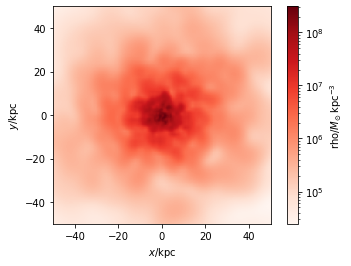

In [223]:
#Taking a quick look at the initial stuff distribution of this sim.
noahSim.physical_units()
pyn.analysis.angmom.faceon(noahSim)
sph.image(noahSim.dm,width=100,cmap='Reds')

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


AttributeError: 'Profile' object has no attribute 'p'

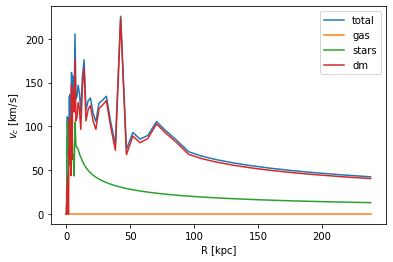

In [224]:
#initial rotation curve for the sim.
noahSim.physical_units()
p = pyn.analysis.profile.Profile(noahSim,min=.01,max=250,type='log',ndim=3)
pg = pyn.analysis.profile.Profile(noahSim.g,min=.01,max=250,type='log',ndim=3)
ps = pyn.analysis.profile.Profile(noahSim.s,min=.01,max=250,type='log',ndim=3)
pd = pyn.analysis.profile.Profile(noahSim.d,min=.01,max=250,type='log',ndim=3)

# make the plot
plt.plot(p['rbins'],p['v_circ'],label='total')
plt.plot(pg['rbins'],pg['v_circ'],label='gas')
plt.plot(ps['rbins'],ps['v_circ'],label='stars')
plt.plot(pd['rbins'],pd['v_circ'],label='dm')

plt.xlabel('R [kpc]')
plt.ylabel(r'$v_c$ [km/s]')
plt.legend()
p.p

SimArray([[2.7050194e-07, 2.7050194e-07, 2.7050194e-07, ...,
           2.7050194e-07, 2.7050194e-07, 2.7050194e-07],
          [2.7050194e-07, 2.7050194e-07, 2.7050194e-07, ...,
           2.7050194e-07, 2.7050194e-07, 2.7050194e-07],
          [2.7050194e-07, 2.7050194e-07, 2.7050194e-07, ...,
           2.7050194e-07, 2.7050194e-07, 2.7050194e-07],
          ...,
          [2.7050194e-07, 2.7050194e-07, 2.7050194e-07, ...,
           2.7050194e-07, 2.7050194e-07, 2.7050194e-07],
          [2.7050194e-07, 2.7050194e-07, 2.7050194e-07, ...,
           2.7050194e-07, 2.7050194e-07, 2.7050194e-07],
          [2.7050194e-07, 2.7050194e-07, 2.7050194e-07, ...,
           2.7050194e-07, 2.7050194e-07, 2.7050194e-07]], dtype=float32, 'Msol kpc**-3')

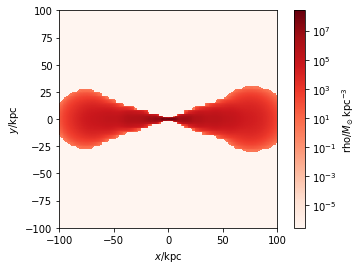

In [220]:
pyn.analysis.angmom.sideon(noahSim)
sph.image(noahSim.d,width=200,cmap='Reds')

In [221]:
np.random.random()

0.5788621589122696

In [222]:
noahSim.star['x']

SimArray([-0.85916724,  4.2865672 ,  2.08397233, -2.3963829 ,  0.81595615,
          -0.82330399,  0.28257983, -5.4319196 ,  1.39642793,  2.45106788,
           6.54470054, -4.85524228, -1.34064095,  2.71223929, -1.60612541,
           2.47803027, -0.39498832,  2.35699165, -9.14129396,  0.14386455,
           1.02205606,  0.9113133 , -0.27886201,  1.26018683, -6.90272656,
          -0.58497577, -0.90882544, -7.97215643, -2.96203259,  3.39780612,
          -3.52048188, -5.24950563,  0.17995215,  1.72097399,  2.31022776,
          -0.88995169,  3.23464392, -0.47130742, -2.52091581, -0.33248758,
           1.32789797, -6.05482758,  3.38672475, -0.53048315, 10.06444481,
           1.47387074,  3.60548661, -0.22678273, -7.12266065,  0.23895895,
          -0.37479047, -0.98342318, -6.65024612, -9.71849749,  1.23942259,
          -6.536907  , -0.24652174,  2.49477231,  0.62588935, -0.01816663,
           0.35636218,  0.94195261, -4.89400136, -0.4474118 ,  1.985556  ,
           7.30770909, -1